In [1]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import matplotlib as plt
import pandas as pd
from bs4 import BeautifulSoup
from tabulate import tabulate
import numpy as np

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [3]:
bib = bib_data.entries

### Here are the 3 datasets we will start with.

In [4]:
bib_df = pd.DataFrame.from_dict(bib) # large one from the Bibliography
review_df = pd.read_csv('no_citation_text.csv', dtype='str') # MR numbers who came back with no `GAP` text found inside
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str') # CItations scraped from MathSciNet website

# Larger dataset from Bibliography

* how to deal with NaN missing values ? *

We only need some of these columns, hence we `drop` the rest.

In [5]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

In [6]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [7]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

We reorder the columns.

In [8]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MR` so we cane later merge this dataframe with the other one.

In [9]:
bib_df.columns = ['MR', 'Author', 'Journal', 'Year', 'Publication Type']
bib_df

,MR,Author,Journal,Year,Publication Type
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
...,...,...,...,...,...
3362,2647300,"Zusmanovich, P.",J. Geom. Phys.,2010,article
3363,2735394,"Zusmanovich, P.",J. Algebra,2010,article
3364,3201064,"Zusmanovich, P.",J. Algebra,2014,article
3365,3598575,"Zusmanovich, P.",Linear Algebra Appl.,2017,article


Data types and count of non-null values for each columns.

In [10]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                3159 non-null   object
 1   Author            3367 non-null   object
 2   Journal           3047 non-null   object
 3   Year              3367 non-null   object
 4   Publication Type  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [11]:
bib_df.iloc[3274]

MR                            NaN
Author                 Wegner, A.
Journal                       NaN
Year                         1989
Publication Type    mastersthesis
Name: 3274, dtype: object

In [12]:
bib_df.describe()

,MR,Author,Journal,Year,Publication Type
count,3159,3367,3047,3367,3367
unique,3158,2511,384,43,10
top,3656296,"Sambale, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


### We will look at the `year` column. There are several anomalies and we need just 4 digits in each cell.

In [13]:
bib_df.sort_values('Year', ascending=False)

,MR,Author,Journal,Year,Publication Type
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [14]:
bib_df['Year'] = bib_df['Year'].str.extract(r'^(\d{4})', expand=False)

In [15]:
bib_df['Year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1989      2
1988      2
1987      2
1990      1
Name: Year, dtype: int64

Now we convert the column Data type back to numeric.

bib_df['Year'] = pd.to_numeric(bib_df['Year'])

bib_df['Year'] = bib_df['Year'].astype(np.int64)

In [16]:
# we use this option to remove the trailing zeors behind the year.
# pd.options.display.float_format = '{:.0f}'.format 

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

#  Corpus and Review

What are the GAP Citation practices ???
The longer the citation is the more details it contains - measure lenght ?

To do
+ check Citations strings lenghts to isolate too short ones

+ website count citations hacing `gap.com` string to measure how many mention the website
+ remaining HTML characters

Two citations containing Singapore instead of GAP present.



In [17]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [18]:
pd.options.display.max_colwidth = 157

In [19]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_citation(mrno):
    r = corpus_df[corpus_df['MR'] == mrno]
    return r.at[r.index[0],'Citation'], r.at[r.index[0],'Version']

In [20]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

def get_c(mrno):
    r = merged_df[merged_df['MR'] == mrno]
    return r

In [21]:
# Python lectures by Dr Konovalov 
# https://studres.cs.st-andrews.ac.uk/CS2006/Lectures/Python/L08-dataset.pdf

unknown_ver = []

def get_version(s):
    match = re.search("(?:(\d+\.(?:\d+\.)*\d+))", s, re.IGNORECASE)
    if match != None:
        return match.group(1)
    else:
        print('No match:', s)
        unknown_ver.append(s)

In [22]:
def is_package(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("package", citation, re.IGNORECASE) != None:
        print('***Package***:', mrno, citation)
        return 'Package'
    else:
        print('***Not a Package***:', mrno, citation)
        return series['Version']

In [23]:
def website_check(series):
    mrno = series['MR']
    citation = series['Citation']
    version = series['Version']
    if re.search("www|\.net|http", citation, re.IGNORECASE) != None:
        print('***Provided Website***:', mrno, citation)
        return 'Yes'
    else:
        print('***Not Provided***:', mrno, citation)
        return 'No'

* First we create the version column. Then we fill its cells with the version, where provided.

In [24]:
corpus_df.insert(loc=2, column='Version', value=' ')

In [25]:
corpus_df['Version'] = corpus_df['Citation'].map(get_version)

No match: GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
No match: Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
No match: M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [10].
No match: W. Nickel, NQ, 1998, A refereed GAP 4 package, see [8].
No match: Gamble, G., Nickel, W., O'Brien, E.A.: ANU p-Quotient–p-Quotient and p-Group Generation Algorithms (2006). An accepted GAP 4 package, available also in MAGMA
No match: M. Schönert et al, GAP: groups, algorithm and programming, © 1992 by Lehrstuhl D für Mathematik, distributed with the GAP software via ftp from samson.math.rwth-aachen.de.
No match: M. Delgado, P. A. G

No match: The GAP Group (2008). Groups, Algorithms, and Programming, Available at http://www.gap-system.org (2008). Accessed January 2, 2013.
No match: The GAP Group, Groups, Algorithms, and Programming, http://www.gap-system.org (2008).
No match: The GAP Group (2008). Groups, algorithms, and programming. Available at: http://www.gap-system.org.
No match: The GAP Group, Groups, Algorithms, and Programming, http://www.gap-system.org (2008).
No match: Groups, Algorithms, Programming—A System for Computational Discrete Algebra (GAP) http://www.gap-system.org
No match: Groups, Algorithms, Programming—A System for Computational Discrete Algebra (GAP) http://www.gap-system.org
No match: Besche H U, Eick B and O'Brien E A 2002 SmallGroups—A GAP package www.gap-system.org/Packages/sgl.html
No match: Nagy, G. P., Vojtěchovský, P. (2007). LOOPS: Computing with quasigroups and loops in GAP. Available at: http://www.math.du.edu/petr/loops. 
MR2379126
No match: M. Schönert et al., "GAP—Groups, Algo

No match: M. Schönert et al., GAP-Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, RWTH, Aachen (1995).
No match: V. I. Mysovskikh, "A counterexample to the long-standing conjecture of Z. I. Borevich by GAP," in: Extended Abstracts of the Workshop CASC'98, St. Petersburg, April (1998), pp. 101–102.
No match: V. I. Mysovskikh, "Investigation of subgroup embeddings by the computer algebra package GAP," in: Computer Algebra in Scientific Computing, Proceedings of the Second Workshop CASC'99, Springer (1999), pp. 309–315. 
MR1729633
No match: M. Schönert et al., GAP-Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, RWTH, Aachen (1995).
No match: V. I. Mysovskikh, "Investigation of Subgroup Embeddings by the computer algebra package GAP," in: Computer Algebra in Scientific Computing. Proceedings of the 2nd Workshop CASC'99, Springer (1999), pp. 309–315. 
MR1729633
No match: M. Schönert et al., GAP - Groups, Algorithms, and Programming, Lehrstuhl D für Mathemat

In [26]:
corpus_df['Version'].value_counts()

4.4         460
4.4.12      310
4.3         232
4.4.10      136
4.2         127
           ... 
3.2           1
1.8.4         1
2.12          1
4.4.2006      1
10.01.16      1
Name: Version, Length: 196, dtype: int64

Then we apply the function which chekcs if it is a case of citing GAP Package. Packages are connected to GAP, but technically is a separate piece of software. In entries citing GAP package there is no version of GAP provided hence we will fill the `Version` cell with `Package`.

In [27]:
corpus_df['Version'] = corpus_df.apply(is_package,axis=1)

***Not a Package***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Package***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Not a Package***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Not a Package***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Not a Package***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not a Package***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Not a Package***: MR2287843 The G

***Package***: MR3544422 G. Gamble, W. Nickel and E. A. O'Brien, ANU $p$-Quotient — $p$-quotient and $p$-group generation algorithms, (2006); an accepted GAP 4 package, available also in MAGMA.
***Not a Package***: MR3544422 The GAP group, GAP — groups, algorithms, and programming — a system for computational discrete algebra, version 4.7.8, Aachen, Braunschweig, Fort Collins, St. Andrews (2015); http://www.gap-system.org.
***Not a Package***: MR2854847 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, 2006, http://www.gap-system.org.
***Not a Package***: MR3283836 GAP Group 2014. GAP—Groups, Algorithms, and Programming, Version 4.7.4. http://www.gap-system.org.
***Not a Package***: MR2746050 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.4.10. Aachen. St. Andrews, http://www.gap-system. org. 2007.
***Package***: MR3658506 A. Bächle and L. Margolis, HeLP – A GAP package for torsion units in integral group rings, preprint (2015), arXiv:1507.08174 

***Package***: MR2827200 M. Delgado, P. A. García-Sánchez and J. Morais, "Numericalsgps": A GAP Package on Numerical Semigroups, http://www.gap-system.org/Packages/numericalsgps.html.
***Package***: MR2863434 M. Delgado, P. García-Sánchez and J. Morais, "numericalsgp": A GAP package on numerical semigroups (2008), http://www.gap-system.org/Packages/numericalsgps.html.
***Package***: MR3022135 M. Delgado, P.A. García-Sánchez, and J. Morais, "numericalsgps'': A GAP Package on Numerical Semigroups, http://www.gap-system.org/Packages/numericalsgps.html.
***Package***: MR2900095 M. Delgado, P.A. García-Sánchez, J. Morais, Numericalsgps: a GAP package on numerical semigroups, http://www.gap-system.org/Packages/numericalsgps.html.
***Not a Package***: MR1856917 Schöenert, Martin et al. GAP–Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule; Aachen, Germany, fifth edition, 1995.
***Not a Package***: MR1483783 M. Schönert et al., "GAP—G

***Not a Package***: MR1831996 M. Schönert et al., GAP - Groups, Algorithms and Programming, Release 3.4, Lehrstuhl D für Mathematik, Rheinisch-Westfälische Technische Hochschule, Aachen, Germany (1995).
***Not a Package***: MR2420025 The GAP Group, GAP—Groups, Algorithms and Programming, Version 4.4, 2005, http://www.gap-system.org.
***Not a Package***: MR2765323 The GAP Group: GAP—Groups Algorithms and Programming, Version 4.3 (2002). http://www. gap-system.org
***Not a Package***: MR3702969 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.7.6 (2014). http://www.gap-system.org
***Not a Package***: MR2503241 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2005, http://www.gap-system. org.
***Not a Package***: MR3364217 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.7.6, 2014. http://www.gap-system.org.
***Not a Package***: MR3254782 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.6.4, 2013 (http://www.gap-syst

***Package***: MR2395197 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numericalsgps": a GAP [12] package on numerical semigroups. http://www.gap-system.org/Packages/numericalsgps.html 
MR3493240
***Not a Package***: MR2395197 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4 (2004). http://www.gap-system.org
***Package***: MR2863437 M. Delgado and J. Morais, SgpViz, a GAP package to visualize finite semigroups, Version 0.998 (2008), http://www.gap-system.org/Packages/sgpviz.html.
***Not a Package***: MR2863437 The GAP Group, GAP—groups, algorithms, and programming, version 4.4 (2004), http://www.gap-system.org.
***Not a Package***: MR3042586 M. Delgado, P. A. García-Sánchez and J. Morais, "NumericalSgps'', A GAP pack- age for numerical semigroups, current version number 0.97 (2011). Available via http://www.gap-system.org/.
***Package***: MR3150926 M. Delgado, "Intpic, a GAP package for drawing integers", [Online]. Available: http://www.fc.up.pt/cmup/mdelgado/softw

***Package***: MR3175315 Hegarty, F.: HAPPERMUTAHEDRAL-Version 1.0 (2011), a package for the GAP computational algebra system. http://hamilton.nuigalway.ie
***Not a Package***: MR3175315 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.9 (2006). http://www.gap-system.org
***Not a Package***: MR3418068 Heiko Dietrich, Bettina Eick, Dörte Feichtenschlager, Investigating $p$-groups by coclass with GAP, in: Computational Group Theory and the Theory of Groups, in: Contemp. Math., vol. 470, Amer. Math. Soc., Providence, RI, 2008, pp. 45–61. 
MR2478413
***Not a Package***: MR3418068 The GAP Group, GAP – groups, algorithms, and programming, version 4.5.6, http://www.gap-system.org, 2013.
***Package***: MR2655291 G. Ellis, $\ssf{HAP}$ - Homological Algebra Programming. A package for the computer algebra system $\ssf{GAP}$. http://www.gap-system.org/Packages/hap.html.
***Package***: MR2478414 J.-G- Dumas, F. Heckenbach, D. Saunders and V. Welkmar, Simplicial Homology, a packag

***Not a Package***: MR2737675 The GAP Group: GAP—Groups, Algorithms and Programming, Version 4.4, 2006 (http://www.gap-system.org)
***Not a Package***: MR2326329 The GAP Group, gap—Groups, Algorithms, Programming, Version 4.4.7, 2006 (http://www.gap-system.org).
***Not a Package***: MR2326329 T. Breuer, Manual for the GAP Character Table Library Version 1.1 (Lehrstuhl D für Mathematik, Rheinisch West-fälische Hochschule, Aachen, 2004).
***Not a Package***: MR1656569 M. Schönert et al., "GAP—Groups, Algorithms and Programming," 5th ed., Lehrstuhl D für Mathematik, Rheinisch Westfälische Technische Hochschule, Aachen, Germany, 1995.
***Not a Package***: MR2028065 The GAP Group, Aachen, St. Andrews, GAP—Groups, Algorithms, and Programming, Version 4.2, http://www-gap.dcs.st-and.ac.uk/$\sim$gap, 2000.
***Not a Package***: MR2568350 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9, http://www.gap-system.org, 2006.
***Not a Package***: MR2610749 The GAP Group, GAP - Gro

***Not a Package***: MR3987718 The GAP Group, GAP groups algorithms, and programming, Version 4.10.0, 2018, available at http://www.gap-system.org.
***Not a Package***: MR1610479 M. SCHO NERT et al., GAP 3.4 manual (groups, algorithms, and programming) (Lehrstuhl D fu r Mathematik, RWTH Aachen, 1994).
***Not a Package***: MR2153793 The GAP Group, `GAP - groups, algorithms, and programming', Version 4.4, 2004, http://www.gap-system.org. 125, 126, 128, 133, 134, 135, 136, 141
***Not a Package***: MR2724218 The GAP Group. (2004). GAP–Groups, Algorithms, and Programming. Version 4.4. http://www.gap-system.org.
***Package***: MR2724218 Nagy, G. P., Vojtěchovský, P. LOOPS: Computing with Quasigroups and Loops. Version 2.0.0. Package for GAP, http://www.math.du.edu/loops.
***Not a Package***: MR2859875 GAP Group, GAP - Groups, algorithms, and programming, version 4.4.10, 2007, http://www.gap-system.org.
***Package***: MR2859875 G. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and l

***Not a Package***: MR3484742 GAP - Groups, Algorithms, and Programming, Version 4.7.5; 2014. (http://www.gap-system.org)
***Not a Package***: MR2522415 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4.9, http://www.gap-system.org, 2006.
***Package***: MR2522415 L.H. Soicher, The DESIGN package for GAP, Version 1.3, http://designtheory.org/software/gap\_design/, 2006.
***Not a Package***: MR2221258 The GAP Group, `GAP - Groups, Algorithms, and Programming', Version 4.4, 2005, http://www.gap-system.org. 160
***Not a Package***: MR4217096 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.9.3, 2018, https://www.gap-system.org
***Not a Package***: MR4205764 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.9.3, 2018, https://www.gap-system.org.
***Not a Package***: MR4208918 The GAP Group, GAP – Groups, Algorithms and Programming, Version 4.9.1, 2018, http://www.gap-system.org.
***Not a Package***: MR2998792 The GAP Group, GAP - Groups,

***Not a Package***: MR3613284 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.6, 2014, available at http://www.gap-system.org
***Not a Package***: MR2243244 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2 (2002). http://www.gap-system.org.
***Not a Package***: MR2162128 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
***Not a Package***: MR2290906 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2005.
***Package***: MR2429351 B. Eick and W. Nickel. Polycyclic—computing with polycyclic groups. A refereed GAP 4 package, Version 2.1 (2006).
***Not a Package***: MR2429351 The GAP Group. GAP—Groups, algorithms, programming, Version 4.4 (2005). http://www.gap-system.org.
***Package***: MR2429351 W. Nickel. NQ—Nilpotent quotients of finitely presented groups. A refereed GAP 4 package, Version 2.2 (2007).
***Not a Package***: MR2447151 The GAP Group, G

***Not a Package***: MR3860884 The GAP Group, 2017. GAP – groups, algorithms, and programming, version 4.8.7. http://www.gap-system.org.
***Not a Package***: MR4204560 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.9.1 (2020). (https://www.gap-system.org/Contacts/cite.html)
***Not a Package***: MR2259067 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
***Not a Package***: MR1838096 M. Schönert et al., GAP - Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH Aachen, fifth edition, 1995, (http://www.gap.dcs.stand.ac.uk/gap).
***Not a Package***: MR2336398 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4; 2004, (http://www.gap-system.org)
***Not a Package***: MR3272374 GAP-Group, GAP—Groups, Algorithms, and Programming, version 4.7.2, http://www.gap-system.org, 2013.
***Package***: MR3272374 M. Neunhöeffer, GAP package recog, version 1.2, http://www-groups.mcs.st-and.ac.uk/$\sim

***Not a Package***: MR2976355 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.3; 2002, http://www.gap-system.org.
***Package***: MR2976355 L.H.Soicher, The GRAPE package for GAP, Version 4.3, 2006, http://www.maths.qmul.ac.uk/$\sim$leonard/grape.
***Package***: MR4120752 R. Abbott, J. Bray, S. Linton, S. Nickerson, S. Norton, R. Parker, I. Suleiman, J. Tripp, P. Walsh and R. Wilson, AtlasRep—a GAP Package, Version 2.1.0, 2019, available online at http://www.math.rwth-aachen.de/~Thomas.Breuer/atlasrep/doc/manual.pdf.
***Not a Package***: MR4120752 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.8.7, 2017, available online at https://www.gap-system.org/Releases/4.8.7.html.
***Package***: MR3879081 M. Delgado, P. A. Garcia-Sanchez and J. Morais, Numerical Sgps, a package for numerical semigroups, Version 1.0.1, http://www.fc.up.pt/cmup/mdelgado/numericalsgps/, June 2015. Refereed GAP package. 
MR3493240
***Not a Package***: MR3879081 The GAP Group, GAP

***Not a Package***: MR2531764 Groups, algorithms and programming, Lehrstuhl $\roman{D}$ für Mathematik, RWTH Aachen, 1994. Available at http://www.gap-system.org/.
***Not a Package***: MR2592492 The Gap Group, Gap - Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.
***Package***: MR2592492 L.H. Soicher, The Grape package for Gap, Version 4.3, 2006. http://www.maths.qmul.ac.uk/$\sim$leonard/grape/.
***Not a Package***: MR4187238 The Gap Group, Gap–groups, algorithms, and programming, http://www.gap-system.org, 2015.
***Not a Package***: MR1615333 M. Schönert (ed.), Groups, Algorithms and Programming. Lehrstuhl D für Mathe- matik, RWTH Aachen, Germany (1994) available via anonymous ftp on the server ftp://ftp-gap.dcs.st-and.ac.uk/pub/gap
***Not a Package***: MR2371432 G.A.P. Groups, Algorithm and Programming Computer Algebra System. http://www.gap-system.org/$\sim$gap
***Package***: MR3169635 Delgado, M., García-Sánchez, P. A., Morais, J. "numericalsg

In [28]:
corpus_df['Version'].value_counts()

Package      730
4.4          454
4.4.12       310
4.3          212
4.4.10       136
            ... 
3.1.0          1
1405.5063      1
0911.5589      1
1.1.3          1
10.01.16       1
Name: Version, Length: 100, dtype: int64

Now we will create a `website` coulmn to indicate if such is provided. Then we fill each cell using  a Regex to search citations for the GAP website.

In [29]:
corpus_df.insert(loc=3, column='Website', value=' ')

In [30]:
corpus_df['Website'] = corpus_df.apply(website_check, axis=1)

***Provided Website***: MR4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
***Provided Website***: MR3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
***Provided Website***: MR3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
***Provided Website***: MR3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
***Provided Website***: MR3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
***Not Provided***: MR1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
***Provided Webs

***Provided Website***: MR4156098 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.1, http://www.gap-system.org, 2019.
***Provided Website***: MR2555698 M. Dutour Sikirić. "Polyhedral," a package for GAP. Available online (http://www.liga.ens.fr/$\sim$dutour/Polyhedral/index.html), 2006.
***Provided Website***: MR2555698 The GAP Group. GAP: Groups. Algorithms, and Programming, Version 4.4. Available online (http://www.gap-system.org/), 2006.
***Not Provided***: MR3780407 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3, gap-system.org, 2016.
***Provided Website***: MR2850041 he GAP Group, GAP - Groups, Algortihms and Programming, Version 4.4.10, 2007, (http://www.gap-system.org).
***Not Provided***: MR4128140 Zs. Balogh and V. Laver, RAMEGA – RAndom MEthods in Group Algebras Version 1.0.0. The GAP Group, 2020.
***Provided Website***: MR4128140 The GAP Group, GAP – Groups Algorithms and Programming Version 4.11.0., https://www.gap-system.org 

***Provided Website***: MR2381018 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4 (2006). http://www.gap-system.org.
***Provided Website***: MR2728996 GAP—Groups, Algorithms, and Programming, Version 4.4.12, (http://www.gap-system. org), 2008.
***Provided Website***: MR2812661 The GAP Group, GAP—Groups, Algorithms, and Programming, Ver. 4.4.12, 2008. (http://www.gap-system.org).
***Provided Website***: MR2900224 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10, 2007, www.gap-system.org.
***Provided Website***: MR2900886 The GAP Group, $GAP$ groups, algorithms, and programming, version 4.4.12 (2008), http://www.gap-system.org.
***Provided Website***: MR3783590 GAP: The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org.
***Provided Website***: MR4025666 T. Breuer, The GAP character table library, version 1.2.2, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib, Mar 2013, GAP package.
***Provided Web

***Provided Website***: MR2859920 S. Cicalò, W.A. de Graaf, C. Schneider, LieAlgDB–a GAP package, Version 2.1, November 2010. Available from: $<$www.sztaki.hu/$\sim$schneider/Research/LieAlgDB$>$.
***Provided Website***: MR2859920 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008. Available from: $<$http://www.gap-system.org$>$.
***Provided Website***: MR2862197 Björn Assmann, Guarana. A GAP4 package, http://www.gap-system.org/Packages/guarana.html, 2007.
***Provided Website***: MR2862197 Serena Cicalò, Willem A. de Graaf, LieRing. A GAP package, http://science.unitn.it/$\sim$degraaf/liering.html, 2011.
***Provided Website***: MR2862197 The GAP Group, GAP - groups, algorithms, and programming, version 4.4, http://www.gap-system.org, 2004.
***Provided Website***: MR1822856 M. Schönert et al., GAP: Groups, algorithms, and programming, 4th ed., Lehr-stuhl D für Mathematik, RWTH Aachen, 1994. See http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
***Provided Website***: 

***Provided Website***: MR2234814 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.3; St. Andrews, Aachen, 1999. (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap). The GAP libraries specific to this paper are available at: http://www.math.du.edu/$\sim$petr in section research| computing.
***Provided Website***: MR2431758 The GAP Group, GAP - Groups, Algorithms, and Programming, version 4.4.9, 2006. http://www.gap-system.org.
***Provided Website***: MR2431758 G.P. Nagy, P. Vojtěchovský, LOOPS: Computing with quasigroups and loops, version 1.5.0, package for GAP. Distribution website: http://www.math.du.edu/loops.
***Provided Website***: MR2818949 The GAP Group. GAP Groups, Algorithms, and Programming, Version 4.4.12 (2008). www.gap-system.org.
***Provided Website***: MR2818949 G. P. Nagy and P. Vojtěchovský. LOOPS: Computing with quasigroups and loops, version 2.1.0, package for GAP. Distribution website: www.math.du.edu/loops.
***Provided Website***: MR3338085 The GAP 

***Provided Website***: MR3366018 GAP: Groups, Algorithms, Programming — a system for computational discrete algebra, The GAP Group, http://www.gap-system.org.
***Provided Website***: MR3910672 P. A. García-Sánchez and A. Sánchez-R.-Navarro, 4ti2gap, GAP wrapper for 4ti2, https://github.com/gap-packages/4ti2gap.
***Provided Website***: MR3910672 M. Costantini and W. de Graaf, singular, The GAP interface to Singular, Version 12.04.28 (2012), (GAP package), http://www.gap-system.org/HostedGap-Packages/singular/.
***Provided Website***: MR3910672 M. Delgado, P. A. García-Sánchez and J. Morais, NumericalSgps, a package for numerical semigroups, Version 1.0.1 (2015), (Refereed GAP package), http://www.gap-system.org. 
MR3493240
***Provided Website***: MR3910672 The GAP Group, GAP - Groups, Algorithms, and Programming, 2014, http://www.gap-system.org.
***Provided Website***: MR3910672 S. Gutsche, M. Horn and C. Söger, NormalizInterface, GAP wrapper for Normaliz, Version 0.9.5 (2016), (GAP pa

***Provided Website***: MR2043998 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.3. Available from World Wide Web (http://www.gap-system.org), 2003.
***Provided Website***: MR2043998 G. Havas, C. Ramsay, G. Gamble, and A. Hulpke. "ACE: A GAP 4 Package Providing an Interface to the Advanced Coset Enumerator." Available from World Wide Web (http://www.gap-system.org/Share/ace.html), 2003.
***Provided Website***: MR2101831 Gamble, G., Havas, G., Hulpke, A. (2002). PGRelFind: a GAP example using the ACE share package. {http://www.gap-system.org/-gap/Intro/pgrelfind.html} (accessed September 2002).
***Provided Website***: MR2228634 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004, http://www.gap-system.org/.
***Provided Website***: MR2160572 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4 (2004), http://www.gap-system.org.
***Provided Website***: MR2476442 The GAP Group, GAP Groups, Algorithms, and Programming, Version 4.4, 2

***Provided Website***: MR2425695 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4, 2006 (http://www.gap-system.org).
***Provided Website***: MR3591163 The GAP Group, GAP – groups, algorithms, and programming, version 4.7.5, http://www.gap-system.org, 2014.
***Provided Website***: MR4194289 The GAP Group, GAP: groups, algorithms, and programming, software (2004) Version 4.4 Available at http://www.gap-system.org
***Not Provided***: MR2763946 A. Dooms, E. Jespers, A. Konovalov and H. Verrill, Congruence—congruence subgroups of $\roman {SL}_{2}(\Bbb {Z})$, GAP package.
***Provided Website***: MR2763946 GAP, `Groups, algorithms, programming—a system for computational discrete algebra', http://www.gap-system.org.
***Provided Website***: MR1961010 GAP4, The GAP-Group, GAP-Groups, Algorithms and Programming, Version 4.2; 2000, {http://www.gap-system.org}.
***Provided Website***: MR3095482 The GAP Group: GAP—Groups, Algorithms, and Programming, version 4.6.4 (2013). http:

***Provided Website***: MR1876312 Lübeck, F. (1999). EDIM—Elementary Divisors and Integer Matrices, RWTH Aachen, Lehrstuhl D für Mathematik, (a refereed share package for GAP (1999), see http://www.gap-system.org/share/edim.html).
***Provided Website***: MR2356848 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.4.7, http://www.gap-system.org, 2006.
***Provided Website***: MR3682589 T. Breuer, CTblLib, the $\ssf{GAP}$ character table library, version 1.1.3 ed., Mar 2004, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib.
***Provided Website***: MR3682589 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.4.9, 2006, http://www.gap-system.org.
***Provided Website***: MR4196561 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.2, https://www.gap-system.org, 2019.
***Provided Website***: MR4069221 GAP – Groups, Algorithms, and Programming, Version 4.7.6, http://www.gap-system.org, Nov 2014.
***Provided Website***: MR4102116 T. Br

***Not Provided***: MR1757829 M. Schönert et al., GAP-Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, RWTH, Aachen (1995).
***Not Provided***: MR1757830 V. I. Mysovskikh, "Investigation of Subgroup Embeddings by the computer algebra package GAP," in: Computer Algebra in Scientific Computing. Proceedings of the 2nd Workshop CASC'99, Springer (1999), pp. 309–315. 
MR1729633
***Not Provided***: MR1757830 M. Schönert et al., GAP - Groups, Algorithms, and Programming, Lehrstuhl D für Mathematik, RWTH Aachen (1995).
***Provided Website***: MR2659212 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2008.
***Provided Website***: MR3835579 The GAP Group, GAP-groups, algorithms and programming, Version 4.4.12, http://www.gap-system.org/, 2008.
***Provided Website***: MR3431577 `The GAP Group: GAP—Groups, Algorithms, and Programming', version 4.7.6, 2014, http://www.gap-system.org.
***Provided Website***: MR2552586 The GAP Group, GAP

***Provided Website***: MR3776814 The GAP group, GAP-Groups, Algorithms, and Programming, Version 4.7.4, http://www.gapsystem.org, 2014.
***Provided Website***: MR3969474 The GAP group (2014). GAP-Groups, Algorithms, and Programming, Version 4.7.4, http://www.gap-system.org
***Provided Website***: MR4150726 The GAP Group. (2014). Algorithms, and programming, Version 4.7.4. http://www.gap-system.org.
***Provided Website***: MR2594680 G. Ellis, GAP package HAP, 2008, http://hamilton.nuigalway.ie/Hap/www/index.html.
***Provided Website***: MR2594680 The GAP group, GAP - Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org.
***Provided Website***: MR2594680 D. F. Holt, B. Eick and E. O'Brien, GAP package cohomolo, 2008, http://www.warwick.ac.uk/staff/D.F.Holt/cohomolo/.
***Provided Website***: MR2594680 D. F. Holt, B. Eick and E. O'Brien, GAP package kbmag, 2009, http://www.warwick.ac.uk/$\sim$mareg/kbmag.
***Provided Website***: MR2820156 The GAP Group, `GA

***Provided Website***: MR2342712 The GAP Group, `GAP Groups, Algorithms, and Programming, Version 4.4.4', 2004, http://gap-system.org. 343, 347
***Provided Website***: MR2749253 The GAP group, Aachen and St. Andrews, GAP, Groups, Algorithms and Programming, Version 4.1 (1999), http://gap-system.org.
***Provided Website***: MR2728949 The GAP Group (GAP—Groups, Algorithms, and Programming, Version 4.4.10), 2008 (http://www.gap-system.org).
***Provided Website***: MR2926571 The GAP Group, 2006. GAP—Groups, Algorithms, and Programming, Version 4.4.12. Available at http://www.gap-system.org.
***Provided Website***: MR4061988 The GAP Group: GAP (Groups, algorithms, and programming), a system for computational discrete algebra, Version 4.9.2. https://www.gap-system.org, 2018.
***Not Provided***: MR1939111 M. Schönert et al., GAP—Groups, Algorithms and Programming, Lehrstuhl D für Mathematik, RWTH, Aachen, 1994.
***Provided Website***: MR2537368 The GAP Group, GAP—Groups, Algorithms, and Prog

# Merging the two dataframes with the equivalent of SQL `join`

df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]
df_filtered = df[df.mrnumber.isin(mrs)]

The `MR` column in `corpus_df` dataframe has the letters "MR" preceeding each number, first we will remove these letters, the the MR number format is the same in both datasets.

In [31]:
corpus_df['MR'] = corpus_df['MR'].str.extract('(\d+)', expand=False)
corpus_df

,MR,Citation,Version,Website
0,4056124,"GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.",None,Yes
1,3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.: ""Numerical Sgps"", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. A...",Package,Yes
2,3942387,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes
3,3354065,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes
4,3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes
...,...,...,...,...
3537,3988630,"M. Delgado, P. A. García-Sánchez and J. Morais. Numericalsgps: a ${\ssf gap}$ package on numerical semigroups, (http://www.gap-system.org/Packages/numeri...",Package,Yes
3538,1801202,"L.H. Soicher, GRAPE: a system for computing with graphs and groups, in: L. Finkelstein and W.M. Kantor, eds., Groups and Computation, DIMACS Series in Di...",None,Yes
3539,2558870,"L. Bartholdi, Functionally recursive groups, http://www.gap-systems.org/Manuals/pkg/fr/doc/manual.pdf.",None,Yes
3540,2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality gap in binary quadratic programming, Available from: http://www.optimization-online.org/DB_FILE/2010/01/2512...",None,Yes


In [32]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3542 entries, 0 to 3541
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MR        3542 non-null   object
 1   Citation  3542 non-null   object
 2   Version   3003 non-null   object
 3   Website   3542 non-null   object
dtypes: object(4)
memory usage: 55.4+ KB


In [33]:
bib_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                3159 non-null   object
 1   Author            3367 non-null   object
 2   Journal           3047 non-null   object
 3   Year              3363 non-null   object
 4   Publication Type  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


* With the following code we are joining the two datasets on the `MR` column and using `corpus_df` as a base. The resulting dataset will have as many lines as `corpus_df` but all columns from `bib_df` will be added, hence we will have much more information to work with.

In [34]:
merged_df = pd.merge(bib_df, corpus_df, on='MR', how='right', indicator=True)

merged_df = merged_df.dropna()
merged_df.info()

* We need to convert the `Year` column cells to integers, in order for the visualisations to work fine. We will use the `.astype` method, but before taht we have to remove all `NaN` entries, from that column.

In [35]:
merged_df = merged_df.dropna(subset=['Year'])

In [36]:
type(merged_df['Year'][3])

str

In [37]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3542
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MR                3531 non-null   object  
 1   Author            3531 non-null   object  
 2   Journal           3440 non-null   object  
 3   Year              3531 non-null   object  
 4   Publication Type  3531 non-null   object  
 5   Citation          3531 non-null   object  
 6   Version           2995 non-null   object  
 7   Website           3531 non-null   object  
 8   _merge            3531 non-null   category
dtypes: category(1), object(8)
memory usage: 238.5+ KB


In [38]:
merged_df['Year'] = merged_df['Year'].astype(np.int64)

In [39]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3542
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MR                3531 non-null   object  
 1   Author            3531 non-null   object  
 2   Journal           3440 non-null   object  
 3   Year              3531 non-null   int64   
 4   Publication Type  3531 non-null   object  
 5   Citation          3531 non-null   object  
 6   Version           2995 non-null   object  
 7   Website           3531 non-null   object  
 8   _merge            3531 non-null   category
dtypes: category(1), int64(1), object(7)
memory usage: 252.3+ KB


In [40]:
type(merged_df['Year'][3])

numpy.int64

* We can use the following iteration loop to browse the resulting merged dataframe. By borwsing the raw data we can make sure everything is alright and spot any remaining issues or anomalies. In our case there are some remaining special characters, which we will remove as best as we can.

In [41]:
for index, row in merged_df.iterrows():
    print(row['MR'], row['Citation'])

4056124 GAP – Groups, algorithms, programming - a system for computational discrete algebra, www.gap-system.org.
3942387 Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 
MR3493240
3942387 The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017
3354065 The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.
3646312 The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.
1864795 M. Schönert et al. GAP - Groups, Algorithms, and Programming (Lehrsthul D für Mathematik, Reinisch-Westflische Technische Hochschule, Aachen, Germany, fifth ed., 1995.)
2287843 The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).
2175389 The GAP Group, GAP-Groups, Algorithms, and pro

2009317 M. Schönert, et al., GAP: Groups, Algorithms and Programming, RWTH, Aachen, 1993.
2171236 GAP — Groups, Algorithms, and Programming, Version 4.3, The GAP Group, 2002, http://www.gap-system.org.
2066313 Martin Schönert et al., GAP: Groups, algorithms and programming, RWTH Aachen, 1993.
2218347 The GAP Group, "GAP: Groups, Algorithms, and Programming", 2002, Available at http://www.gap-system.org/. Version 4.3.
2320997 GAP—Groups, Algorithms, and Programming, version 4.4, The GAP Group, 2005, http://www.gap-system.org.
2595090 The GAP Group, GAP - Groups, Algorithms, and Programming. Version 4.4.10, 2007. http://www.gap-system.org
3084710 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.4.10, 2008. http://www.gap-system.org.
3305041 The GAP Group. "GAP—Groups, Algorithms, and Programming," Version 4.4.10. Available at http://www.gap-system.org, 2008.
3746628 The GAP Group, "GAP —Groups, Algorithms, and Programming, Version 4.5", 2016, http://www.gap-system.org.
3

2209165 GAP, 2004. GAP–Groups, Algorithms, and Programming, version 4.4. The GAP Group. http://www.gap-system.org.
3834786 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.7, http://www.gap-system.org, 2017.
3492193 Roney-Dougal, C., Hulpke, A. GAP Data Library "Primitive Permutation Groups." Available at http://www.gap-system.org/Datalib/prim.html.
2643930 G. Pfeiffer, Character tables of Weyl groups in GAP, Bayreuth. Math. Schr. 47 (1994), 165–222. 
MR1285208
3404000 The GAP Group. GAP–Groups, Algorithms, and Programming, Version 4.4, 2004. http://www.gap-system.org (Last accessed September 28, 2014).
2293468 The GAP Group, `GAP - Groups, Algorithms, and Programming', http://www.gap-system.org, Version 4.3, 2002.
2587034 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.12, 2008. http://www.gap-system.org.
4187240 M. Delgado, P.A. García-Sánchez, J. Morais, NumericalSgps, a package for numerical semigroups, Version 1.1.8 (Refereed GAP package), 

3786416 M. Delgado, P. A. García-Sánchez and J. Morais, "NumericalSgps", A GAP package for numerical semigroups, Version 1.1.0 (2017), (Refereed GAP package), https://gap-packages.github.io/numericalsgps. 
MR3493240
3786416 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.7, 2017, http://www.gap-system.org.
3990993 Delgado, M., García-Sánchez, P.A., Morais, J.: "NumericalSgps"—a GAP package, Version 1.1.5 (2017) http://www.gap-system.org/Packages/numericalsgps.html. Accessed 25 Sept 2017
3990993 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.8.4 (2016). http://www.gap-system.org. Accessed 4 June 2016
2894438 The GAP Group, GAP—Groups, Algorithms, and Programming. Version 4.4.9; 2006, http://www.gap-system.org.
3765459 Y. Muntyan, D. Savchuk, AutomGrp – GAP package for computations in self-similar groups and semigroups, version 1.2.4, 2014.
2845567 The GAP Group, GAP—Groups, Algorithms, Programming—A System for Computational Discrete Algebra, Vers

4163066 W.A. de Graaf, T. GAP Team, SLA, computing with simple Lie algebras, Version 1.5.2 (Refereed GAP package), https://gap-packages.github.io/sla/, 2019.
4163066 C. Jefferson, E. Jonauskyte, M. Pfeiffer, R. Waldecker, Images - minimal and canonical images, a GAP package, Version 1.1.0, http://gap-packages.github.io/images/, 2018. 
MR3906181
3169410 Schönert, M. et al. (1995). GAP—Groups, Algorithms, and Programming. Lehrstuhl ${\roman{D}}$ für Mathematik, RWTH Aachen, fifth edition. Home page: http://www.gap-system.org.
2902724 Draisma, J.: blattner, an implementation of the realisation formula. GAP-code: http://www.win.tue.nl/$\sim$jdraisma/index.php?location=programs
2902724 The GAP Group.: GAP—Groups, Algorithms, and Programming, Version 4.3. http://www.gap-system.org (2002)
2234814 The GAP Group, GAP—Groups, algorithms, and programming, Version 4.3; St. Andrews, Aachen, 1999. (Visit http://www-gap.dcs.st-and.ac.uk/$\sim$gap). The GAP libraries specific to this paper are availab

3912237 The GAP Group, GAP-Groups, Algorithms and Programming, Version 4.4.12, 2008, https://www.gap-system.org.
3949732 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.9.1; (2018). https://www.gapsystem.org
2166805 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, http://www.gap-system.org, 2002.
1935079 GAP (2000). GAP—Groups, Algorithms, and Programming. Aachen, St Andrews, The GAP Group; http://www-gap.dcs.st-and.ac.uk/$\sim$gap.
2639308 Michel, J., 1997. Garside and braid monoids and groups. In: The GAP Manual. (Chapter 82). Available at http://www.math.jussieu.fr/$\sim$jmichel/htm/CHAP082.htm.
1480786 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," Lehrstuhl D für Mathematik, fourth ed., RWTH Aachen, Germany, 1994.
1769289 M. Schönert et al., "GAP—Groups, Algorithms, and Programming," 4th ed., Lehrstuhl D für Mathematik, Aachen, Germany, 1994.
1685620 M. Schönert et al. - GAP - Groups, algorithms, and programming, Lehrstuhl D fü

3248801 `GAP–Groups, Algorithms and Programming', www.gap-system.org.
2654520 "The GAP group," in: GAP-Groups. Algorithms and Programming. Version 4.4; 2006 (www.gap-system.org).
3659332 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.6, http://www.gap-system.org, 2016.
3275646 The GAP Group, GAP—groups, algorithms, and programming, Version 4.5.5, 2012, available at: http://www.gap-system.org.
1972024 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews. 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
2108123 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.2, Aachen, St. Andrews, 1999. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap)
2064755 GAP Group, GAP – Groups, algorithms, and programming. Version 4.2 (Aachen, St Andrews, 1999) (http://www.gap-system.org/).
2684148 The GAP Group, GAP—Groups Algorithms, and Programming, Version 4.4.12, http://www.gap-system.org, 2008.
2968225 The GAP Group: GAP—Groups, Algori

3224268 A. M. Cohen and D. A. H. Gijsbers, GBNP, a Non–commutative Gröbner Bases Package for GAP 4. 2007. http://www.win.tue.nl/$\sim$amc/pub/grobner
3169443 The GAP Group. GAP–Groups, Algorithms, and Programming. Version 4.4.12 of 17-Dec-2008. Available at http://www.gap-system.org. Accessed Feb 4, 2013.
3863486 T. Breuer, CTblLib, – GAP's Character Table Library package, version 1.2.1, http://www.math.rwth-aachen.de/~Thomas.Breuer/ctbllib, 2012.
3863486 The GAP Group, GAP – Groups, Algorithms, and Programming, version 4.8.7, http://www.gap-system.org, 2017.
2333176 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2004.
2350989 The GAP Group, GAP—Groups, Algorithms, and Programming (Version 4.4; 2006), http://www.gap-system.org.
2333443 The GAP Group: GAP–Groups, Algorithms, and Programming. Version 4.4, http://www.gap-system.org (2006)
2489902 The GAP Group, GAP–groups, algorithms, and programming, version 4.4; http://www.gap-system.org,

2209789 G. Pfeiffer, Character tables of Weyl Groups in GAP, Lehrstuhl D Für Mathematik, RWTH, Aachen, Templergraben 64, D-5100, Aachen, Germany.
3144163 GAP Group: GAP - Groups, Algorithms and Programming, Version 4.4. Aachen, St Andrews 2008. (http://www-gap.dcs.st-and.ac.uk/$\sim$gap).
3204610 The GAP Group, GAP - Groups, Algorithms and Programming, Version 4.2, Aachen, St Andrews, 2000, (http://www-gap.dcs.st-and.ac.uk/~gap).
3620981 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.3, 2002. (http://www.gap-system.org).
3613284 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.7.6, 2014, available at http://www.gap-system.org
2243244 The GAP Group. GAP—Groups, Algorithms, and Programming, Version 4.2 (2002). http://www.gap-system.org.
2162128 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.3, 2002, http://www.gap-system.org.
2290906 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, http://www.gap-system.org, 2

2333119 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.3, 2002. http://www.gap-system.org.
1423329 M. Schönert, et al., GAP (Groups Algorithms and Programming) Version 3.4, RWTH Aachen.
1807659 M. Schönert et al., "GAP: Groups Algorithms and Programming," Ver. 3.4, Lehrstuhl D für Mathematik, RWTH Aachen, 1994.
3920964 Thomas Breuer, The GAP Group, private communication.
3920964 The GAP Group, GAP – groups, algorithms, and programming, version 4.10.0, https://www.gap-system.org, 2018.
3635817 G. Gamble, A. Hulpke, G. Havas, C. Ramsay, M. Horn, GAP Package ACE, http://gap-packages.github.io/ace/, 1998.
3635817 The GAP Group, GAP – Groups, Algorithms, and Programming, Version 4.8.3, http://www.gap-system.org, 2016.
1829749 The GAP group (Aachen, St. Andrews), GAP-Groups, Algorithms and Programming, version 4.2, 1999.
2644429 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.9; 2006 (http://www.gap-system.org).
3162438 The GAP Group: GAP—Groups, Algori

2892513 The GAP Group, GAP—Groups: Algorithms, and Programming, Version 4.4.10, http://www.gap-system.org (2007)
2925155 The GAP Group, GAP-Groups: Algorithms, and Programming, Version 4.4.10. http://www.gap-system.org (2007)
2787664 The GAP Group, GAP–Groups, Algorithms, and Programming, Version 4.4.10, http://www.gap-system.org, 2007.
2961301 The GAP Group: GAP—Groups, Algorithms, and Programming, Version 4.4.10. http://www.gap-system.org (2007)
3010848 The GAP Group, GAP–Groups, Algorithms, Programming–A System for Computational Discrete Algebra, http://www.gap-system.org, Version 4.4.7, 2006.
3123866 The GAP Group, GAP-Groups, Algorithms, and Programming, Version 4.4.10, 2007, http://www.gap-system.org.
3265322 The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.5.6; 2012. http://www.gap-system.org.
3227444 The GAP Group, GAP–groups, algorithms, and programming, version 4.5.6, 2012, http://www.gap-system.org.
3036002 The GAP Group: Groups, Algorithms, and Programming,

We use Regex to further purify the `Citation` column, removing some remaining special characters.

In [42]:
merged_df['Citation'] = merged_df['Citation'].str.replace(r'[\\\$\{\}\^]', '')
merged_df['Citation'] = merged_df['Citation'].str.replace(r'(ssf)', '')

<ipython-input-42-e299e3edd306>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['Citation'] = merged_df['Citation'].str.replace(r'[\\\$\{\}\^]', '')
<ipython-input-42-e299e3edd306>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_df['Citation'] = merged_df['Citation'].str.replace(r'(ssf)', '')


##### We remove the unnecessary `merge` column and add a `lenght` column to reflect the character lenght of each citation.

In [43]:
merged_df = merged_df.drop(['_merge'], axis=1)
merged_df['Lentght'] = merged_df['Citation'].apply(len)
merged_df = merged_df.dropna()
merged_df

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A Mat. RACSAM,2019,article,"Delgado, M., García-Sánchez, P.A., Morais, J.: ""Numerical Sgps"", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. A...",Package,Yes,183
2,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A Mat. RACSAM,2019,article,"The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017",4.7.5,Yes,125
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article,"The GAP – Groups, Algorithms and Programming. Version 4.4.12, 2008. www.gap-system.org.",4.4.12,Yes,87
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and Niemeyer, A. C.",J. Pure Appl. Algebra,2017,article,"The GAP Group, GAP–Groups, Algorithms, and Programming, 4.7.8, 2015, http://www.gap-system.org.",4.7.8,Yes,95
6,2287843,"Abdollahi, A. and Jafarian Amiri, S. M. and Hassanabadi, A. M.",Houston J. Math.,2007,article,"The GAP Group, GAP - Groups, Algorithms, and Programming, Version 4.3; 2002, (http://www.gap-system.org).",4.3,Yes,105
...,...,...,...,...,...,...,...,...,...
3529,1695079,"Mathas, A.",J. Algebraic Combin.,1999,article,"M. Schönert et al., ""Gap: groups, algorithms, and programming,"" Lehrstuhl D für Mathematik, RWTH Aachen, 3.4.4 edition, 1997.",3.4.4,No,125
3532,2592492,"McInroy, J. and Shpectorov, S.",Discrete Math.,2010,article,"The Gap Group, Gap - Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.",4.4.10,Yes,106
3533,2592492,"McInroy, J. and Shpectorov, S.",Discrete Math.,2010,article,"L.H. Soicher, The Grape package for Gap, Version 4.3, 2006. http://www.maths.qmul.ac.uk/simleonard/grape/.",Package,Yes,106
3537,3169635,"Rosales, J. C. and García-Sánchez, P. A.",Comm. Algebra,2014,article,"Delgado, M., García-Sánchez, P. A., Morais, J. ""numericalsgps"": A gap package on numerical semigroups. Available (http://www.gap-system.org/Packages/nume...",Package,Yes,169


### Now we split the extended dataset in two dataframes for further analysis

### Pure GAP citations  

In [149]:
gap_df = merged_df[merged_df['Version'] != 'Package']
gap_df = gap_df.dropna()
gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2219 entries, 2 to 3532
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                2219 non-null   object
 1   Author            2219 non-null   object
 2   Journal           2219 non-null   object
 3   Year              2219 non-null   int64 
 4   Publication Type  2219 non-null   object
 5   Citation          2219 non-null   object
 6   Version           2219 non-null   object
 7   Website           2219 non-null   object
 8   Lentght           2219 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 112.7+ KB


### GAP Packages Citations

In [45]:
pac_df = merged_df[merged_df['Version'] == 'Package']
pac_df = pac_df.dropna()
pac_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 1 to 3538
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MR                694 non-null    object
 1   Author            694 non-null    object
 2   Journal           694 non-null    object
 3   Year              694 non-null    int64 
 4   Publication Type  694 non-null    object
 5   Citation          694 non-null    object
 6   Version           694 non-null    object
 7   Website           694 non-null    object
 8   Lentght           694 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 35.2+ KB


In [46]:
gap_df[gap_df['Lentght'] < 75]

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght
253,2176489,"Ash, A. and Pollack, D. and Sinnott, W.",J. Number Theory,2005,article,"GAP4, Version: 4.3fix4. Available: http://www.gap-system.org.",4.3,Yes,61
355,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013,article,"The GAP Group, GAP–Groups, Algorithms, Programming, v. 4.5.7, 2012",4.5.7,No,66
730,2301234,"Burness, T. C.",J. Algebra,2007,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,74
731,2344583,"Burness, T. C.",J. Algebra,2007,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,74
732,2344583,"Burness, T. C.",J. Algebra,2007,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,74
733,2344584,"Burness, T. C.",J. Algebra,2007,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,74
734,2344584,"Burness, T. C.",J. Algebra,2007,article,"The GAP Group, GAP—Groups, Algorithms, and Programming, Version 4.4, 2004.",4.4,No,74
743,3219555,"Burness, T. C. and Guralnick, R. M. and Saxl, J.",Israel J. Math.,2014,article,"The GAP Group, GAP–Groups, Algorithms and Programming, Version 4.4, 2004.",4.4,No,73
900,2242478,"Chesnokov, A. A. and Haemers, W. H.",Linear Algebra Appl.,2006,article,"GAP—Groups, Algorithms and Programming, Version 4.3, 2002.",4.3,No,58
965,1909574,"Cousineau, G.",Theoret. Comput. Sci.,2002,incollection,"The GAP Group, GAP: Groups, Algorithms and Programming, Version 4.2, 2000.",4.2,No,74


y = gap_df['Year']
ry = gap_df.to_numeric('ReleaseYear')
tail = y - ry
#gap_df.insert(loc=2, column='Tail', value=' ')
gap_df['Tail'] = [gap_df['Year']]
gap_df

In [47]:
get_c('3092787')

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght
354,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013,article,"Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with permutability, v.0.03, available at http://personales.upv...",Package,Yes,185
355,3092787,"Ballester-Bolinches, A. and Cosme-Llópez, E. and Esteban-Romero, R.",Cent. Eur. J. Math.,2013,article,"The GAP Group, GAP–Groups, Algorithms, Programming, v. 4.5.7, 2012",4.5.7,No,66


In [48]:
merged_df.loc[354]['Citation']

'Ballester-Bolinches A., Cosme-Llópez E., Esteban–Romero R., Permut: A GAP4 package to deal with permutability, v.0.03, available at http://personales.upv.es/simresteban/gap/permut-0.03/'

# Visualisations

### Website

<AxesSubplot:title={'center':'Website statistics on the whole data'}, ylabel='Provided?'>

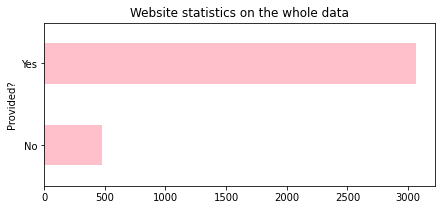

In [49]:
web_chart = corpus_df['Website'].value_counts()
web_chart = web_chart.sort_values(ascending=True)
web_chart.plot(kind="barh", figsize=(7, 3), title='Website statistics on the whole data', 
                xlabel='Provided?', ylabel='Count', color='pink')

<AxesSubplot:title={'center':'Website statistics on the Pure GAP data only'}, ylabel='Provided?'>

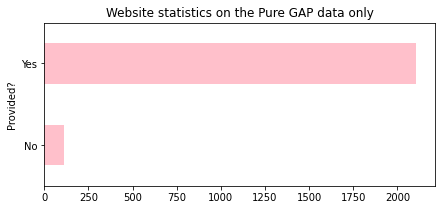

In [50]:
web_gap = gap_df['Website'].value_counts()
web_gap = web_gap.sort_values(ascending=True)
web_gap.plot(kind="barh", figsize=(7, 3), title='Website statistics on the Pure GAP data only', 
                xlabel='Provided?', ylabel='Count', color='pink')

<AxesSubplot:title={'center':'Website statistics on the Package citation data'}, ylabel='Provided?'>

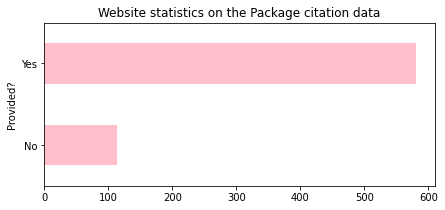

In [51]:
web_pac = pac_df['Website'].value_counts()
web_pac = web_pac.sort_values(ascending=True)
web_pac.plot(kind="barh", figsize=(7, 3), title='Website statistics on the Package citation data', 
                xlabel='Provided?', ylabel='Count', color='pink')

In [52]:
site_year = merged_df.groupby('Website').count()
site_year

,MR,Author,Journal,Year,Publication Type,Citation,Version,Lentght
Website,,,,,,,,
No,226,226,226,226,226,226,226,226
Yes,2687,2687,2687,2687,2687,2687,2687,2687


from pandas.plotting import parallel_coordinates

parallel_coordinates(all_years, "Year")

### Lenght
* Most citations are around 110 characters long.

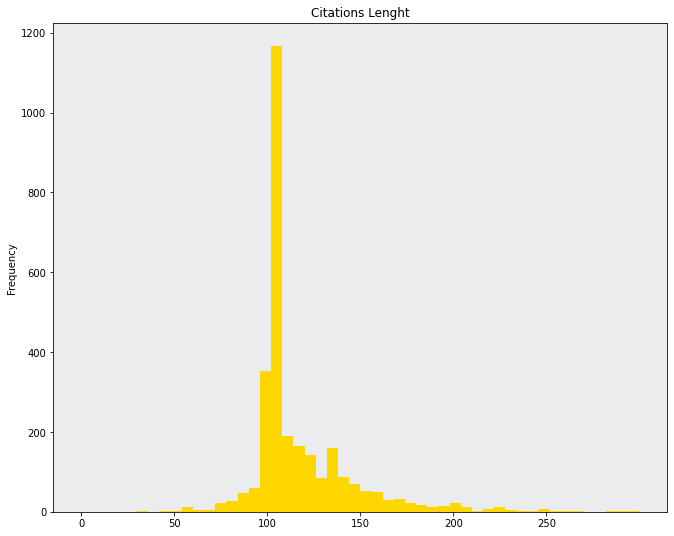

In [53]:
merged_df['Lentght'] = merged_df['Citation'].apply(len)
cit_len = merged_df['Lentght'].plot(kind='hist', bins=50, figsize=(11,9), stacked=True, 
                         xticks = range(0, 300, 50), 
                         range=(0, 300), 
                         color='gold', 
                         title='Citations Lenght', 
                         xlabel="lenght")
cit_len.set_facecolor('#ebeced')


year_df = merged_df.sort_values(by='Year', ascending=False)
year_df.dropna()
num = year_df['Journal'].count()
year_df.plot(x='Year', y=num, kind='barh')


### Version

<AxesSubplot:title={'center':'Top 50 most cited GAP versions'}, xlabel='Version', ylabel='Count'>

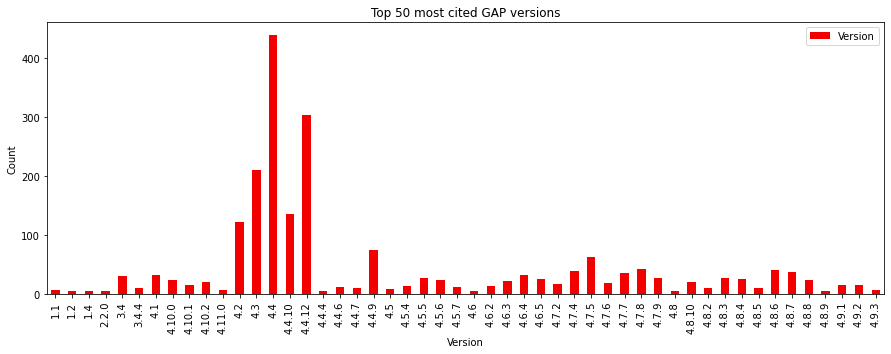

In [54]:
ver = gap_df['Version'].value_counts()
ver = ver.head(50)
ver = ver.to_frame()
ver = ver.sort_index() # sort chrono. compare version numbers
ver = ver.dropna()
ver.plot(kind="bar", figsize=(15, 5), title='Top 50 most cited GAP versions', xlabel='Version', 
                ylabel='Count', color='#f20000')

* We can see that the most popular GAP versions cited are subversions of GAP 4, between 4.2 and 4.4

In [55]:
gap_df['Version'].value_counts()

4.4         439
4.4.12      303
4.3         211
4.4.10      135
4.2         122
           ... 
3.2           1
5.7           1
2.19          1
4.5.3         1
10.01.16      1
Name: Version, Length: 97, dtype: int64

### Authors

* Top 20 authors citing GAP and its packages in their work.

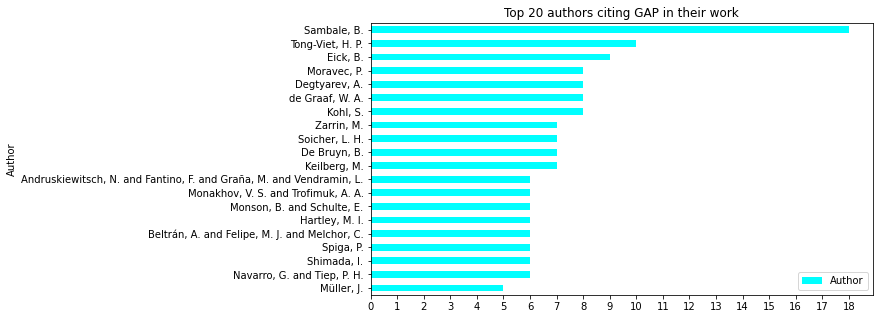

In [56]:
authors = gap_df['Author'].value_counts()
top = authors.head(20)
top = top.sort_values(ascending=True)
top = top.to_frame()
chart = top.plot(kind="barh",
                 figsize=(9,5), title='Top 20 authors citing GAP in their work', 
                 xlabel='Author', 
                 ylabel='Count', color='cyan', 
                  xticks=range(0, 19, 1))
# how do we treat joint papers ?

* Top 20 authors citing GAP Packages

In [57]:
author = pac_df['Author'].value_counts()
top20 = author.head(20)
top20 = top20.sort_values(ascending=False)
top20 = top20.to_frame()
top20

#chart = top20.plot(kind="bar",
#                 figsize=(9,5), title='Top 20 authors citing GAP Packages', 
#                 xlabel='Author', 
#                 ylabel='Count', color='brown', 
#                  xticks=range(0, 19, 1))

,Author
"Bächle, A. and Margolis, L.",10
"Koshitani, S. and Müller, J. and Noeske, F.",10
"Soicher, L. H.",8
"Eick, B.",7
"Douglas, A. and Repka, J.",6
"Kohl, S.",6
"Eick, B. and Horn, M.",6
"Fernandes, V. H.",5
"Cant, A. and Eick, B.",5
"Dabbaghian-Abdoly, V.",5


* Accuracy + site, ver, year
* Countries + to be provided
* GET function + simplicity is key

### Year

##### Barchart dislaying number of GAP citations per year.

* GAP citation counts for each year, sorted chronologically.

<AxesSubplot:title={'center':'Annual GAP citations data'}, xlabel='Year', ylabel='Count'>

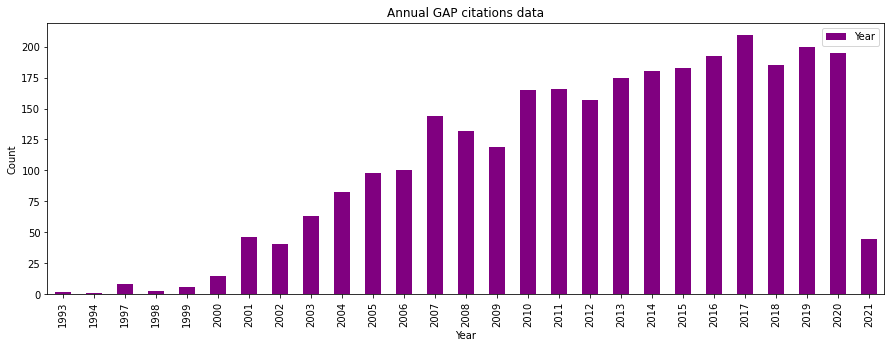

In [58]:
year_chrono = merged_df['Year'].value_counts()
chrono_df = year_chrono.to_frame()
chrono = chrono_df.sort_index()
chrono.plot(kind="bar", figsize=(15, 5), title='Annual GAP citations data', xlabel='Year', 
                ylabel='Count', color='purple')

### Top 20 journals citing GAP.

In [59]:
top_journals = gap_df['Journal'].value_counts()
top_20 = pd.DataFrame(top_journals.head(20))
top_20.reset_index()

,index,Journal
0,J. Algebra,307
1,Comm. Algebra,146
2,J. Algebra Appl.,76
3,Discrete Math.,74
4,J. Symbolic Comput.,57
5,J. Group Theory,54
6,J. Pure Appl. Algebra,51
7,Des. Codes Cryptogr.,46
8,Internat. J. Algebra Comput.,45
9,LMS J. Comput. Math.,42


Only for alternative, useful for copy/paste plain text - quick to load.
Try to allign on the left - journals.

In [60]:
headers = ['Journal name', 'GAP Citations count']
print(tabulate(top_20, headers = headers, tablefmt = 'pretty'))

+------------------------------+---------------------+
|         Journal name         | GAP Citations count |
+------------------------------+---------------------+
|          J. Algebra          |         307         |
|        Comm. Algebra         |         146         |
|       J. Algebra Appl.       |         76          |
|        Discrete Math.        |         74          |
|     J. Symbolic Comput.      |         57          |
|       J. Group Theory        |         54          |
|    J. Pure Appl. Algebra     |         51          |
|     Des. Codes Cryptogr.     |         46          |
| Internat. J. Algebra Comput. |         45          |
|     LMS J. Comput. Math.     |         42          |
|     Arch. Math. (Basel)      |         33          |
|       Israel J. Math.        |         33          |
|     European J. Combin.      |         28          |
|       J. Combin. Des.        |         28          |
|       Algebra Colloq.        |         27          |
|         

### The most frequent type of work citing GAP: we can see that GAP is predominantly cited in articles - 2976 times.

In [61]:
types_pub = pd.DataFrame(bib_df['Publication Type'].value_counts())
types_pub.columns = ['GAP Citations Count']
types_pub.index.names = ['Publication Type']
types_pub

,GAP Citations Count
Publication Type,
article,2976
incollection,204
inproceedings,54
phdthesis,47
mastersthesis,46
book,31
misc,5
techreport,2
inbook,1


# Releases by year

First we create a copy of our corpus dataset, containing only GAP citations with versions provided, all other entries such as Package citations are removed.

In [62]:
versions_cited = gap_df['Version'].unique()

In [63]:
versions_cited

array(['4.7.5', '4.4.12', '4.7.8', '4.3', '4.4', '4.4.4', '4.6.4',
       '4.7.2', '4.6.5', '4.7.9', '4.8.8', '4.8.9', '4.4.10', '4.5.7',
       '4.7.4', '4.7.7', '4.2', '4.6.12', '4.1', '4.10.0', '4.8.6',
       '4.8.2', '4.10.2', '4.11.0', '4.4.2', '4.8.3', '10.1109', '4.8.7',
       '4.6', '2.12', '4.9.1', '4.4.9', '4.8.4', '4.6.2', '1.2', '4.9.3',
       '4.8.10', '4.5', '4.4.6', '4.4.7', '4.5.5', '1.4', '1.3.3',
       '4.4.11', '5.7', '1.5.4', '4.10.1', '1.0.0', '4.4.10.2007',
       '4.6.3', '1405.5063', '1.1', '3.4', '4.8.5', '4.5.6', '4.11',
       '4.10', '4.9.2', '4.7.6', '4.6.9', '4.5.4', '3.4.4', '4.08.10',
       '0710.3267', '0911.5589', '4.8', '4.9.0', '4.7', '3.3', '2.19',
       '0.97', '10.14760', '1.2.1', '2.2.0', '1.5.1', '3.0', '2.0.0',
       '4.4.2006', '4.5.3', '2.1.0', '3.1.0', '3.4.3', '1.0',
       '55.0810.04', '4.6.1', '4.4.3', '4.8.1', '1.9.6', '1804.09707',
       '3.1', '4.4.5', '1.4.0', '4.46', '4.9', '4.49', '10.01.16', '3.2'],
      dtype=object)

In [64]:
release_dates = { 
    # dates from archive timestamps
    '4.8.2': 2016, # 2016/02/20
    '4.7.9': 2015, # 2015/11/29
    '4.7.8': 2015, # 2015/06/09
    '4.7.7': 2015, # 2015/02/13
    '4.7.6': 2014, # 2014/11/15
    '4.7.5': 2014, # 2014/05/24
    '4.7.4': 2014, # 2014/02/20
    '4.7.3': 2013, # 2014/02/15
    '4.7.2': 2013, # 2013/12/01
    '4.7': 2013,
    '4.6.5': 2013, # 2013/07/20
    '4.6.4': 2013, # 2013/05/04
    '4.6.3': 2013, # 2013/03/18
    '4.6.2': 2013, # 2013/02/02
    '4.5.7': 2012, # 2012/12/14
    '4.5.6': 2012, # 2012/09/16
    '4.5.5': 2012, # 2012/07/16
    '4.5.4': 2012, # 2013/06/04
    '4.5': 2012, 
    # dates below from file creation
    '4.4.12': 2008, # 2008/12/16
    '4.4.11': 2008, # 2008/12/08
    '4.4.10': 2007, # 2007/10/05
    '4.4.9': 2006,  # 2006/11/02
    '4.4.8': 2006,  # 2006/09/29
    '4.4.7': 2006,  # 2006/03/17
    '4.4.6': 2005,  # 2005/09/02
    '4.4.5': 2005,  # 2005/05/13
    '4.4.4': 2004,  # 2004/12/22
    # dates below from http://www.gap-system.org/Download/Updates/index.html
    '4.4.3': 2004,   # May 2004
    '4.4.2': 2004,  # April 2004
    # dates from http://www.gap-system.org/Doc/History/history.html
    # if not stated otherwise
    '4.4': 2004, 
    '4.3': 2002, 
    '4.2': 2000, # http://www.gap-system.org/ForumArchive/Linton.1/Steve.1/Release_.3/1.html
    '4.1': 1999, 
    '3.4': 1997, # assume http://www.gap-system.org/Doc/History/preface_3.4.4.html
}

In [65]:
release_dates.keys()

dict_keys(['4.8.2', '4.7.9', '4.7.8', '4.7.7', '4.7.6', '4.7.5', '4.7.4', '4.7.3', '4.7.2', '4.7', '4.6.5', '4.6.4', '4.6.3', '4.6.2', '4.5.7', '4.5.6', '4.5.5', '4.5.4', '4.5', '4.4.12', '4.4.11', '4.4.10', '4.4.9', '4.4.8', '4.4.7', '4.4.6', '4.4.5', '4.4.4', '4.4.3', '4.4.2', '4.4', '4.3', '4.2', '4.1', '3.4'])

In [66]:
def release_year(version):
    if version in release_dates.keys():
        return release_dates[version]
    else:
        return 'Unknown'

In [67]:
release_year('4.7.2')

2013

In [68]:
gap_df['ReleaseYear'] = gap_df['Version'].map(release_year)

In [69]:
data = gap_df['ReleaseYear'].value_counts()

* Number of Citations by year of cited GAP release, in textual and graphic forms.

In [70]:
data

2004       449
Unknown    403
2008       307
2002       211
2007       135
2000       122
2014       120
2013       112
2015       105
2006        86
2012        84
1999        32
1997        30
2005        13
2016        10
Name: ReleaseYear, dtype: int64

<AxesSubplot:title={'center':'Citations by year of cited GAP release'}, xlabel='Years', ylabel='Count'>

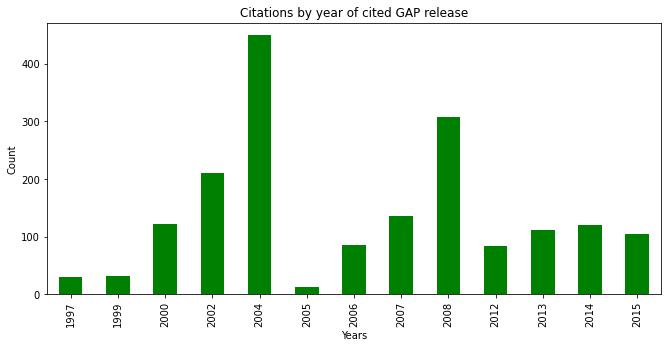

In [71]:
data.loc[sorted(data.index.intersection(range(1997, 2016)))].plot(kind="bar", 
                figsize=(11, 5), title='Citations by year of cited GAP release', xlabel='Years', 
                ylabel='Count', color='green')

<AxesSubplot:title={'center':'pie'}, ylabel='Frequency'>

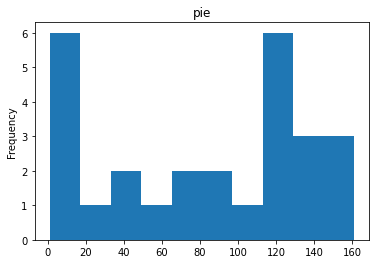

In [127]:
dat.plot(kind="hist", title="pie")

all_years = corpus_df.groupby(['year','ReleaseYear'])['Year'].count()
all_years

In [148]:
get_c('2592492')

,MR,Author,Journal,Year,Publication Type,Citation,Version,Website,Lentght
3532,2592492,"McInroy, J. and Shpectorov, S.",Discrete Math.,2010,article,"The Gap Group, Gap - Groups, Algorithms, and Programming, Version 4.4.10, 2007. http://www.gap-system.org.",4.4.10,Yes,106
3533,2592492,"McInroy, J. and Shpectorov, S.",Discrete Math.,2010,article,"L.H. Soicher, The Grape package for Gap, Version 4.3, 2006. http://www.maths.qmul.ac.uk/simleonard/grape/.",Package,Yes,106


In [146]:
years = gap_df['Year'].unique()
dat = gap_df['Year'].value_counts()
g = gap_df['Version'].value_counts()
ver = gap_df['Version'].unique()

In [155]:
gap_df['Publication Type'].value_counts()

article          2196
incollection       20
inproceedings       3
Name: Publication Type, dtype: int64

In [165]:
yea = gap_df.groupby(['Publication Type', 'Year'])['Publication Type'].count()
yea = pd.DataFrame(data=yea)
yea

Publication Type
Publication Type Year                  
article          1993                 2
                 1994                 1
                 1997                 8
                 1998                 3
                 1999                 4
                 2000                 7
                 2001                26
                 2002                24
                 2003                48
                 2004                68
                 2005                83
                 2006                80
                 2007               116
                 2008               108
                 2009                93
                 2010               130
                 2011               121
                 2012               124
                 2013               128
                 2014               126
                 2015               132
                 2016               126
                 2017               161
                 2018               142
                 2019               146
                 2020               154
                 2021                35
incollection     2000                 3
                 2001                 6
                 2002                 5
                 2003                 5
                 2004                 1
inproceedings    2001                 1
                 2003                 2

<AxesSubplot:title={'center':'Citations by year of cited GAP release'}, xlabel='Years', ylabel='Count'>

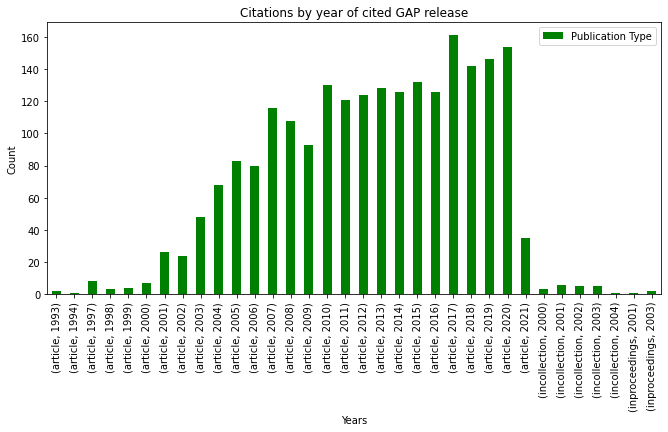

In [166]:
yea.plot(kind="bar", 
                figsize=(11, 5), title='Citations by year of cited GAP release', xlabel='Years', 
                ylabel='Count', color='green')

In [170]:
jou = gap_df.groupby('Year')['Journal'].unique()
jou = pd.DataFrame(data=jou)
jou

,Journal
Year,
1993,[Math. Comp.]
1994,[Math. Comp.]
1997,"[Trans. Amer. Math. Soc., J. Algebra, J. London Math. Soc. (2), Comment. Math. Helv., Proc. Amer. Math. Soc., Proc. London Math. Soc. (3)]"
1998,"[J. Math. Soc. Japan, Math. Comp., J. London Math. Soc. (2)]"
1999,"[J. Algebra, Bull. London Math. Soc., Proc. London Math. Soc. (3), J. Algebraic Combin.]"
2000,"[Discrete Math., J. Algebra, J. Symbolic Comput., Comm. Algebra]"
2001,"[Quaest. Math., Comm. Algebra, J. Algebra, Boll. Unione Mat. Ital. Sez. B Artic. Ric. Mat. (8), Discrete Math. Theor. Comput. Sci., J. Korean Math. Soc.,..."
2002,"[Acta Sci. Math. (Szeged), Comm. Algebra, Internat. J. Algebra Comput., J. Combin. Des., J. Algebra, Des. Codes Cryptogr., Theoret. Comput. Sci., J. Symb..."
2003,"[Discrete Math., Represent. Theory, LMS J. Comput. Math., J. Combin. Theory Ser. A, European J. Combin., J. Symbolic Comput., Comm. Algebra, Finite Field..."


In [92]:
lee = gap_df.groupby('Lentght')
lee.size()

Lentght
54      1
55      1
56      2
58      2
61      1
       ..
265     1
283     1
287     1
288     1
1076    1
Length: 127, dtype: int64

In [142]:
au7 = gap_df['Author'].unique()
au7

array(['Abbas, A. and Assi, A. and García-Sánchez, P. A.',
       'Abdolghafourian, A. and Iranmanesh, M. A.',
       'Abdolghafourian, A. and Iranmanesh, M. A. and Niemeyer, A. C.',
       ..., 'Künzer, M. and Mathas, A.', 'Mathas, A.',
       'McInroy, J. and Shpectorov, S.'], dtype=object)

In [131]:
df2 = gap_df.groupby(['Year', 'ReleaseYear'])['ReleaseYear'].count().unstack('Year').fillna(0)
df2.head(11)

Year,1993,1994,1997,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ReleaseYear,,,,,,,,,,,,,,,,,,,,,
1997,0.0,0.0,5.0,1.0,2.0,7.0,5.0,3.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,0.0,0.0,0.0,2.0,10.0,6.0,4.0,4.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000,0.0,0.0,0.0,0.0,0.0,0.0,15.0,17.0,27.0,21.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,37.0,...,7.0,1.0,7.0,2.0,3.0,1.0,0.0,2.0,3.0,0.0
2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,30.0,19.0,22.0,15.0,19.0,12.0,14.0,10.0,15.0,0.0
2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,6.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,10.0,6.0,8.0,6.0,6.0,3.0,2.0,1.0,0.0
2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.0,61.0,32.0,26.0,13.0,15.0,10.0,6.0,3.0,0.0


c:\users\fliqp_000\appdata\local\programs\python\python38-32\lib\site-packages\numpy\ma\core.py:2825: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: x and y must be the same size

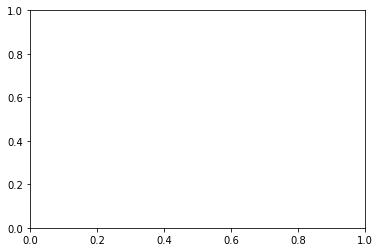

In [143]:
#objects = gap_df['Year']

plt.scatter(lee, years, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Programming language usage')

plt.show()

# Interactive

In [139]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf

In [ ]:
def y_selector(x):
    return gap_df[gap_df['Year'] == x]

In [ ]:
def h(p, q):
    return (p, q)

In [ ]:
gap_df['Year'].value_counts()

In [ ]:
dat = gap_df['Year'].value_counts()
years = dat.index
years = years.sort_values()
years

In [ ]:
yea = interact(y_selector, x=years);

Versions / year
top authors / year
data per year

In [ ]:
def get_info(db, food, nutrient):
    food_info = db
    for word in food.split():
        food_info = food_info[food_info['Food'].str.contains(word, case=False)]
    nutritional_info = food_info[food_info['Nutrient'] == nutrient]
    return nutritional_info

interact(lambda food, nutrient: get_info(db, food, nutrient),
        food='',
        nutrient=list(db['Nutrient'].unique()))

In [140]:
def get_info(db, author, citation):
    auth_info = db
    for word in author.split():
        auth_info = auth_info[auth_info['Author'].str.contains(word, case=False)]
    cit_info = auth_info[auth_info['Citation'] == citation]
    return cit_info

interact(lambda author, citation: get_info(gap_df, author, citation),
        author = '',
        citation = list(gap_df['Citation'].unique()))

interactive(children=(Text(value='', description='author'), Dropdown(description='citation', options=('The GAP…

<function __main__.<lambda>(author, citation)>

In [141]:
yea = widgets.FloatSlider(min=min(gap_df['Year']), max=max(gap_df['Year']), step=1, description='Year')
display(yea)

FloatSlider(value=1993.0, description='Year', max=2021.0, min=1993.0, step=1.0)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


%matplotlib nbagg

x = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('Sine Wave')


def update_plot(amp, phase, freq):
    
    ax.clear()
    y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
    units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
    ax.plot(x, y, label=units.format(amp, phase, freq))
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc=1)
    ax.set_xlabel('$(s)$')
    plt.show()


amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
freq = widgets.FloatSlider(min=1, max=10, value=1, description='Freq:')
    
widgets.interactive(update_plot, amp=amp, phase=phase, freq=freq)